<a href="https://colab.research.google.com/github/EXYNOS-999/MIT_utrc/blob/master/R__viz_adversarial_neural_cryptography_LSTM2_2eves_new_loss_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [97]:
!apt-get install libgmp-dev libmpfr-dev libmpc-dev 
!pip3 install gmpy2
!pip3 install ann_visualizer
!pip3 install graphviz
!pip3 install keras --upgrade
!pip search gmpy2
!pip install pydot-ng
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgmp-dev is already the newest version (2:6.1.2+dfsg-2).
libmpc-dev is already the newest version (1.1.0-1).
libmpfr-dev is already the newest version (4.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
gmpy2 (2.0.8)  - GMP/MPIR, MPFR, and MPC interface to Python 2.6+ and 3.x
  INSTALLED: 2.0.8 (latest)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded

In [98]:
%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape,LSTM, Dropout, GRU
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot


from ann_visualizer.visualize import ann_viz


In [99]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12060392638532486407
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7991935397322253559
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8068802659604291080
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6528685428151783723
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [100]:
#from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

In [101]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    print(X_batch, y_batch)
    return X_batch, y_batch


# Symmetric (secret-key) encryption

## Model `crypto1` (Google)

This model was build according to the specifications from Google's paper *Learning to protect communications with adversarial neural cryptography*.

In [102]:
model_name = 'crypto1'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'
eve2_file = 'models/crypto/' + model_name + '-eve2'

## LSTM

### Network arch

In [103]:
K.clear_session()


##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

x = LSTM(16,return_sequences=True)(areshape)
x = LSTM(64,return_sequences=True)(x)
x = LSTM(128)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
aoutput = Dense(16,activation='relu')(x)
alice = Model([ainput0, ainput1], aoutput, name='alice')
alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)


x = LSTM(16,return_sequences=True)(breshape)
x = LSTM(64,return_sequences=True)(x)
x = LSTM(128)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
boutput = Dense(16,activation='relu')(x)

bob = Model([binput0, binput1], boutput, name='bob')
bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)


x = LSTM(16,return_sequences=True)(ereshape)
x = LSTM(64,return_sequences=True)(x)
x = LSTM(1024)(x)
x = Dense(32,activation='relu')(x)
x = Dropout(0.5)(x)
eoutput = Dense(16,activation='relu')(x)
eve = Model(einput, eoutput, name='eve')
eve.summary()

# Eve network 2
einput1 = Input(shape=(k_bits,)) #key only

edense11 = Dense(units=(c_bits + k_bits))(einput1)
edense11a = Activation('tanh')(edense11)

edense21 = Dense(units=(c_bits + k_bits))(edense11a)
edense21a = Activation('tanh')(edense21)

ereshape1 = Reshape((c_bits + k_bits, 1,))(edense21a)


e11 = LSTM(16,return_sequences=True)(ereshape1)
e21 = GRU(64,return_sequences=True)(e11)
e31 = LSTM(128)(e21)
e41 = Dense(32,activation='relu')(e31)
e51 = Dropout(0.5)(e41)
eoutput2 = Dense(16,activation='relu')(e51)

eve = Model(einput, eoutput, name='eve')
eve2 = Model(einput1, eoutput2, name='eve2')
eve.summary()
eve2.summary()


Model: "alice"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1056        concatenate[0][0]            

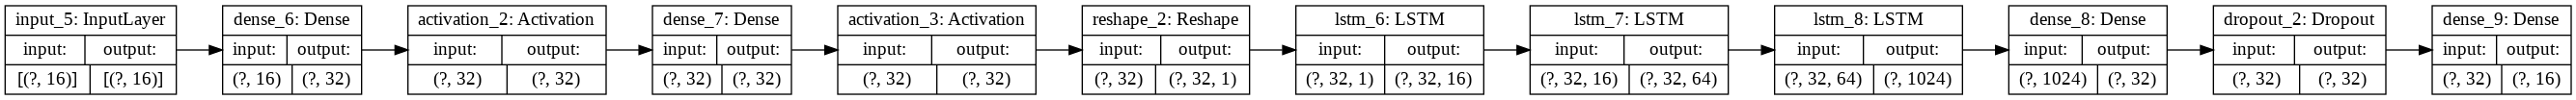

In [104]:
eve_viz = '/tmp/eve_1.png'

plot_model(
    eve,
    to_file="eve_viz.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=True,
    dpi=96,
 
)


In [105]:
'''pydot_file=model_to_dot(
    eve,
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=True,
    dpi=96,
    subgraph=True,
)
'''



'pydot_file=model_to_dot(\n    eve,\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="LR",\n    expand_nested=True,\n    dpi=96,\n    subgraph=True,\n)\n'

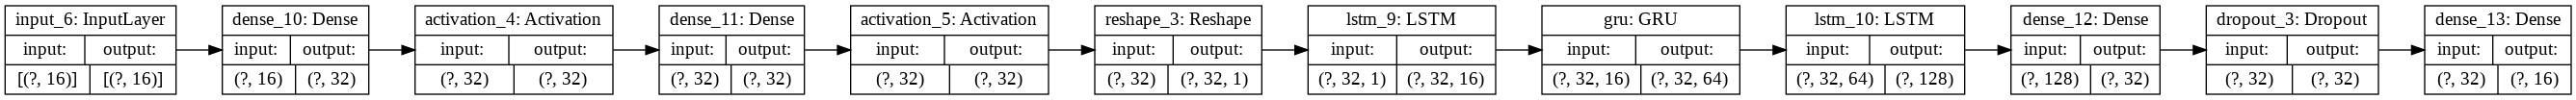

In [106]:
eve2_viz = '/tmp/eve_2_viz.png'
plot_model(
    eve2,
    to_file="eve2_viz.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=True,
    dpi=96,
 
)


In [107]:
from keras.utils.vis_utils import model_to_dot
from graphviz import Digraph
import networkx as nx
from networkx.drawing.nx_agraph import read_dot, write_dot



def convert(name):
    d = {}
    with open(f'{name}.dot', 'r') as f, open(f'{name}-new.dot', 'w') as fn:
        l = f.readline()
        while l != "":
            if 'label' in l:
                id_ = int(l.split()[0])
                op_ = l.split()[2].split('\\')[0]
                if 'Dense' in l or 'Input' in l:
                    n_ = int(l.split()[-1].split(')')[0])
                    op_ = 'InputDense' if 'Input' in l else 'Dense'
                    name = f"\"{id_}[{op_}({n_})]\""
                else:
                    name = f"\"{id_}[{op_}]\""
                d[id_] = name
            elif '->' in l:
                id1 = int(l.split()[0])
                id2 = int(l.split()[-1][:-1])
                nl = f'{d[id1]} -> {d[id2]};\n'
                fn.write(nl)
            else:
                fn.write(l)
            l = f.readline()

def get_num_units(g, name):
    if 'Dense' in name:
        d = list(name).index('(')
        f = list(name).index(')')
        return int(name[d+1:f])
    elif 'Concatenate' in name or 'Dropout' in name:
        return(1)
   
def build(name):
    path = f'{name}-new.dot'
    G = read_dot(path)

    d = {}
    for n in G.nodes:
        if not(n in d):
            d[n] = {
            'num_units': min(10, 20000),
            'succ_str': list(G.successors(n))[:100]
     
        }


    g = Digraph('g', filename=f'{name}-build.gv')
    g.graph_attr.update(splines="True", nodesep='5', ranksep='10') #change dimentions and scaling for viz
    g.attr(arrowShape="none")

    for e in d:
        with g.subgraph(name=f'cluster_{e}') as c:
            c.attr(color="white")

            for i in range(d[e]['num_units']):
                name_d = f'{e}_{i}'
                if 'Input' in e:
                    color = "#33cc33"
                    c.node(name_d, shape="circle",   style="filled", color=color, fontcolor=color)
                elif 'Dropout' in e:
                    color = "#ffcc00"
                    c.node(name_d, shape="rect", style="filled", color=color, fontcolor=color)
                elif 'Concatenate' in e:
                    color = "#993300"
                    c.node(name_d, shape="rect", style="filled", color=color, fontcolor=color)
                elif len(d[e]['succ_str']) == 0: # OUTPUT
                    color = "#ff0000"
                    c.node(name_d, shape="circle", style="filled", color=color, fontcolor=color)
                else:
                    color = "#3498db"
                    c.node(name_d, shape="circle", style="filled", color=color, fontcolor=color)
                for s in d[e]['succ_str']:
                    if 'Dense' in s:
                        for j in range(d[s]['num_units']):
                            name_a = f'{s}_{j}'
                            g.edge(name_d, name_a)
                    else:
                        for j in range(d[s]['num_units']):
                            name_a = f'{s}_{j}'
                            g.edge(name_d, name_a)
    g.view()



def model_visualize(model, name="graph"):
    # Keras model to dot file
    dot_graph = model_to_dot(model, show_shapes=True)
    dot_graph.write(f"{name}.dot", 'dot')

    # Convert dot to specific dot representation
    convert(name)

    # Build to graphvize
    build(name)

In [108]:
from graphviz import Digraph
model_visualize(eve, name="eve")
model_visualize(eve2, name="eve2")
model_visualize(alice, name="alice")
model_visualize(bob, name="bob")

In [52]:
ls

eve2_viz.png  graph-build.gv      graph.dot      plotnn/
eve_viz.png   graph-build.gv.pdf  graph-new.dot  sample_data/


In [70]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')
eve2.compile(loss='mse', optimizer='sgd')

### Loss + Optimizer

In [71]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher
eve2out = eve2( aliceout )
# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
eve2loss = K.mean(  K.sum(K.abs(ainput1 - eve2out), axis=-1)  )
# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = 2*bobloss + K.square(m_bits/2 - eveloss )/( (m_bits//2)**2 )+ K.square(k_bits/2 - eve2loss )/( (k_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001
eveoptim2 = RMSprop(lr=0.001) #default 0.001

# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

# Build and compile the EVE2 model, used for training Eve2 net (with Alice frozen)
#
alice.trainable = False
eve2model = Model([ainput0, ainput1], eve2out, name='eve2model')
eve2model.add_loss(eve2loss)
eve2model.compile(optimizer=eveoptim2)

### Train / save / restore

In [ ]:
abelosses = []
boblosses = []
evelosses = []
eve2losses = []
# epoch = 0
# print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)


In [ ]:
import sys
from tensorflow import keras
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
from datetime import datetime
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
logging.basicConfig(filename=log,level=logging.DEBUG,format='%(asctime)s %(message)s', datefmt='"%Y%m%d-%H%M%S"')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [ ]:

n_epochs = 2000
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 4


while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    eve2losses0 = []
    tic = time.time()
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        # Train the EVE2 network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve2model.train_on_batch([m_batch, k_batch], None)
        
        eve2losses0.append(loss)
        eve2losses.append(loss)
        eve2avg = np.mean(eve2losses0)
        tac  = time.time()
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\r Time: {} | Epoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | eve2: {:2.3f}| bob: {:2.3f}".format(
                tac-tic, epoch, 100 * iteration // n_batches, abeavg, eveavg, eve2avg,bobavg), end="\f")
            logging.info("\r Epoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | eve2: {:2.3f}| bob: {:2.3f}".format(
                tac-tic, epoch, 100 * iteration // n_batches, abeavg, eveavg, eve2avg,bobavg))
            sys.stdout.flush()
       
        # Model Check-Point
        if epoch%10==0:
          name = 'epoch_' + str(epoch + 1) + '_bob_' + str(bobavg) + '.h5'
          model.save(name)
          best_val_acc = val_acc
      
    print()
    epoch += 1
    
print('Training finished.')

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(eve2losses[:steps], label='Eve2')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)
np.savetxt("logs.txt",l)
#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [ ]:

if True: #Don't overwrite by accident
    alice.save('alice' + '.h5', overwrite=True)
    bob.save('bob' + '.h5', overwrite=True)
    eve.save('eve' + '.h5', overwrite=True)
    eve2.save('eve2' + '.h5', overwrite=True)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
ls

In [ ]:
ls

In [ ]:
pwd

### Evaluate

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

### Freeze Alice-Bob

In [ ]:
if False:
    alice = load_model(alice_file + '.h5')
    bob = load_model(bob_file + '.h5')
    eve = load_model(eve_file + '.h5')

aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = Adam()#RMSprop(lr=0.001) #default 0.001

abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

abelosses = []
boblosses = []
evelosses = []

In [ ]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        # Train Eve model only
        #
        alice.trainable = False
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eveloss = evemodel.train_on_batch([m_batch, k_batch], None)
        evelosses0.append(eveloss)
        evelosses.append(eveloss)
        eveavg = np.mean(evelosses0)
        
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        bobloss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(bobloss)
        boblosses.append(bobloss)
        bobavg = np.mean(boblosses0)
        
        # Evaluate the ABE loss
        abeloss = bobloss + ((m_bits/2 - eveloss)**2) / ( (m_bits//2)**2 )
        abelosses0.append(abeloss)
        abelosses.append(abeloss)
        abeavg = np.mean(abelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

## CNN

In [ ]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)

aconv4a = Activation('sigmoid')(aconv4)



aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('sigmoid')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')
bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('sigmoid')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')
eve.summary()

In [ ]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [ ]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

In [ ]:
abelosses = []
boblosses = []
evelosses = []

### Encoding distribution

In [ ]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

Let's plot a few of the encoded vectors' coodinates:

In [ ]:
n_examples = 10000
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 4],
    [ 5, 6, 7, 14]
])

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
m_enc = alice.predict([m_batch, k_batch])

if showAll:
    n_cols = 4
    n_rows = m_enc.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(8, int(8.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i), fontsize=14)
            plt.hist(m_enc[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]), fontsize=12)
            plt.hist(m_enc[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
#plt.savefig("images/" + model_name + "-encall.png", transparent=True) #dpi=100
plt.show()

In [ ]:
# Let's examine various correlations, if any
data_arr = np.c_[m_batch, k_batch, m_enc]

columns = [
    'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 
    'k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 
    'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 
]

data = pd.DataFrame(data=data_arr, index=range(10000), columns=columns)
data.head()

In [ ]:
datac = data[['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15']]
datac.head()

In [ ]:
corr = data.corr()
corrc = datac.corr()

In [ ]:
corrc['c2'].sort_values(ascending=False)

In [ ]:
pd.plotting.scatter_matrix(datac, alpha=0.2, figsize=(12,12))
plt.show()

## Model `crypto2`

Add dense, and allow tanh for codings.

In [ ]:
K.floatx()

In [ ]:
model_name = 'crypto2'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'

### Network arch

In [ ]:
K.clear_session()
kersize = 4

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)

areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aflat = Flatten()(aconv4a)
aoutput = Dense(units=c_bits, activation='tanh')(aflat) #ciphertext

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

bflat = Flatten()(bconv4a)
boutput = Dense(units=m_bits, activation='sigmoid')(bflat) #decrypted message

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)
edense2 = Dense(units=(m_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((m_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eflat = Flatten()(econv4a)
eoutput = Dense(units=m_bits, activation='sigmoid')(eflat) #code break attempt

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [ ]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [ ]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [ ]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = Adam()#RMSprop(lr=0.0015)
eveoptim = Adam()#RMSprop(lr=0.0015) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

### Train / save / restore

In [ ]:
# Keep track of loss at every iteration for the final graph
abelosses = []
boblosses = []
evelosses = []

In [ ]:
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

#plt.savefig("images/" + model_name + "-all.png", transparent=True) #dpi=100
plt.show()

In [ ]:
alice.save(alice_file + '.h5', overwrite=True)
bob.save(bob_file + '.h5', overwrite=True)
eve.save(eve_file + '.h5', overwrite=True)

In [ ]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
#m_enc = np.round(m_enc, 3)
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

# Model 3

# Asymmetric (public-key) encryption

## Model crypto3 (Google)

In [ ]:
# Coming soon

# AI-based encryption (POC)

Let's take model `crypto2`, for which Bob was incredibly accurate while Eve failed to decrypt the messages.

We construct a full encryption, with 32-bit float ciphertexts (vector of dim 8), so each character will encode to 32 * 8 = 256 bits

**Encryption Algorithm:**
* Convert character string to binary
* Pad the binary char encoding string wtih 3 random bits to get a block of 8 bits per character
* Pass 8-bit blocks of the string through the encryption network Bob
* The output is 8-dim vectors of type `float32`, for a total of $8 \cdot 32 = 256$ bits per character
* Convert the output to a binary string by concatenating the binary representation of each component the 8-dim float vector. **This is the encoding**

One could convert this to a character string to see what the messasge might look like. Each character will be a block of 5 (remove 3 bits for padding).

The decryption algorithm is the reverse of the above.

In [ ]:
alice = load_model('models/crypto/crypto2-alice.h5')
bob = load_model('models/crypto/crypto2-bob.h5')
eve = load_model('models/crypto/crypto2-eve.h5')

## Char map and str functions

In [ ]:
block_size_unpadded = 5
block_padding = 3
block_size = block_size_unpadded + block_padding

chrlist = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '!', '?',
    ':', ' '
]
binlist = [
    '00000', '00001', '00010', '00011', '00100', 
    '00101', '00110', '00111', '01000', '01001',
    '01010', '01011', '01100', '01101', '01110', 
    '01111', '10000', '10001', '10010', '10011',
    '10100', '10101', '10110', '10111', '11000',
    '11001', '11010', '11011', '11100', '11101', 
    '11110', '11111'
]

def randombits(n):
    if n == 0:
        return ''
    decvalue = np.random.randint(0, 2**n)
    formatstring = '0' + str(n) + 'b'
    return format(decvalue, formatstring)

def encstr(message, block_padding=0):
    cipher = ""
    for c in message:
        binstr = binlist[chrlist.index(c)]
        binstrpadded = randombits(block_padding) + str(binstr)
        cipher = cipher + binstrpadded
    return cipher, len(message)

def decstr(cipher, n, block_padding=0):
    message = ""
    cipherlength = len(cipher)
    block_size = cipherlength // n
    for i in range(n):
        blockpadded = cipher[block_size*i : block_size*i + block_size]
        blockunpadded = blockpadded[block_padding:]
        character = chrlist[binlist.index(blockunpadded)]
        message = message + character
    return message

In [ ]:
print(encstr('adi', 3))
print(decstr('00010011010001001001001001010011', 4, block_padding=3))

In [ ]:
# Function for converting float to 32-bit binary string
def float_to_binary(value):
    binNum = bin(  ctypes.c_uint.from_buffer(ctypes.c_float(value)).value  )[2:]
    binstr = binNum.rjust(32,"0")
    return binstr

def binary_to_float(binstr):
    intvalue = int(binstr, 2)
    floatvalue = ctypes.c_float.from_buffer(ctypes.c_uint(intvalue))
    return floatvalue.value

# Convert a positive integer num into a bit vector of 'bits' size
def bitarray(num, bits):
    return np.array(list(np.binary_repr(num).zfill(bits))).astype(np.int8)

In [ ]:
key = np.array([[0,0,0,0,0,0,0,0]])
m = 'adi'

m_bin, _ = encstr(m, block_padding=3)
m_bin_len = len(m_bin)
print(m_bin, m_bin_len)

ciphertext = ""
for i in range(m_bin_len // m_bits):
    # read blocks of size m_bits
    binblockstr = m_bin[m_bits*i : m_bits*i + m_bits]
    binblock = np.array(list(binblockstr)).astype(np.int8).reshape(1, m_bits)
    
    floatVector = alice.predict([binblock, key])
    #print(np.round(floatVector,3))
    
    # convert each coordinate of the cipher (float) vector to binary
    # and construct the binary ciphertext
    for j in range(c_bits):
        ciphertext = ciphertext + float_to_binary(floatVector[0][j])
        #print(float_to_binary(floatVector[0][j]))

#print(ciphertext, len(ciphertext)) # ciphertext in binary
print(decstr(ciphertext, n=(len(ciphertext)//8), block_padding=3)) #ciphertext as characters

ciphertext_len = len(ciphertext)
plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    # read the ciphertext in chunks of 32*c_bits bits, i.e one encoding at a time
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    #print(floatVectorbin)
    # convert the binary chunk to an 8-dim float vector (input for AI Bob)
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        #print(floatValuebin)
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    #print(np.round(floatVector,3))
    
    charbinvector = list( (bob.predict([floatVector, key]) > 0.5)[0].astype(int) )
    for j in range(len(charbinvector)):
        plaintextbin = plaintextbin + str(charbinvector[j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

In [ ]:
# How would Eve peform on the above ciphertext?

plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    charbinvector = (eve.predict(floatVector) > 0.5).astype(int)
    for j in range(charbinvector.shape[1]):
        plaintextbin = plaintextbin + str(charbinvector[0][j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

# End